##🎓 Projet pédagogique : Reconnaissance faciale avec MLP

##Présenté Par:

### -Mbery Sene GNING
### -Awa SENE

# 1. Introduction

La reconnaissance faciale est une technologie qui permet d'identifier ou de vérifier l'identité d'une personne à partir d'une image de son visage.  
Dans ce projet, notre objectif est de construire un modèle de reconnaissance faciale en utilisant uniquement un Perceptron Multicouche (MLP), sans réseau convolutif (CNN).

Nous allons travailler sur le prétraitement des images, l'augmentation de données, la construction d'un modèle MLP, l'entraînement, l'évaluation des performances et l'optimisation des hyperparamètres.

*Applications de la reconnaissance faciale :*
- Déverrouillage des smartphones.
- Systèmes de sécurité et de surveillance.
- Authentification biométrique pour les paiements.
- Identification dans les réseaux sociaux.
- Accès sécurisé à des bâtiments ou des services.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

!unzip /content/drive/MyDrive/VisageModel.zip

Archive:  /content/drive/MyDrive/VisageModel.zip
  inflating: VisageModel/Projet_ReconnaissanceFaciale_MLP_Etudiant (1).ipynb  
  inflating: VisageModel/test_vis.csv  
  inflating: VisageModel/train_vis.zip  


In [ ]:
!!unzip /content/VisageModel/train_vis.zip -d /content/images

['Archive:  /content/VisageModel/train_vis.zip',
 '   creating: /content/images/images/',
 '  inflating: /content/images/images/0.jpg  ',
 '  inflating: /content/images/images/1.jpg  ',
 '  inflating: /content/images/images/10.jpg  ',
 '  inflating: /content/images/images/100.jpg  ',
 '  inflating: /content/images/images/1000.jpg  ',
 '  inflating: /content/images/images/10000.jpg  ',
 '  inflating: /content/images/images/10001.jpg  ',
 '  inflating: /content/images/images/10002.jpg  ',
 '  inflating: /content/images/images/10003.jpg  ',
 '  inflating: /content/images/images/10004.jpg  ',
 '  inflating: /content/images/images/10005.jpg  ',
 '  inflating: /content/images/images/10006.jpg  ',
 '  inflating: /content/images/images/10007.jpg  ',
 '  inflating: /content/images/images/10008.jpg  ',
 '  inflating: /content/images/images/10009.jpg  ',
 '  inflating: /content/images/images/1001.jpg  ',
 '  inflating: /content/images/images/10010.jpg  ',
 '  inflating: /content/images/images/100

In [ ]:
# prompt: read a csv file and have a dataframe
import pandas as pd
df_train = pd.read_csv('/content/images/train.csv')
print(df_train.head())
df_test = pd.read_csv('/content/VisageModel/test_vis.csv')
df_test.head()




  image_names  class
0   11413.jpg      1
1    9863.jpg      1
2     997.jpg      0
3    5950.jpg      0
4   10454.jpg      1


,image_names
0,5603.jpg
1,1286.jpg
2,9815.jpg
3,8865.jpg
4,9306.jpg


In [ ]:
# prompt: read some images in a folder using skimage

from skimage.io import imread
from skimage.transform import resize
import os

def read_images(dir,df,number=12196):
  images = []
  i = 0
  for filename in os.listdir(dir):
    if filename.endswith('.jpg') and filename in list(df['image_names']):
      image = imread(os.path.join(dir, filename))
      image = resize(image, (224, 224))
      images.append(image)
      i=i+1
    if i == number:
      break
  return images

def get_names(dir,number=12196):
  names = []
  i = 0
  for filename in os.listdir(dir):
    if filename.endswith('.jpg'):
      #name = filename.split('.')[0]
      #print(name)
      names.append(filename)
      i=i+1
    if i == number:
      break
  return names

def get_labels(list_images,df):
  labels = []

  for im in list_images:

    index = df.index[df['image_names'] == im]


    label = df.loc[index.values,'class']
    # print(type(label))

    labels.append(label.values)

  return labels

train_images = read_images('/content/images/images',df_train,6)
images_labels = get_names('/content/images/images',6)
train_labels = get_labels(images_labels,df_train)




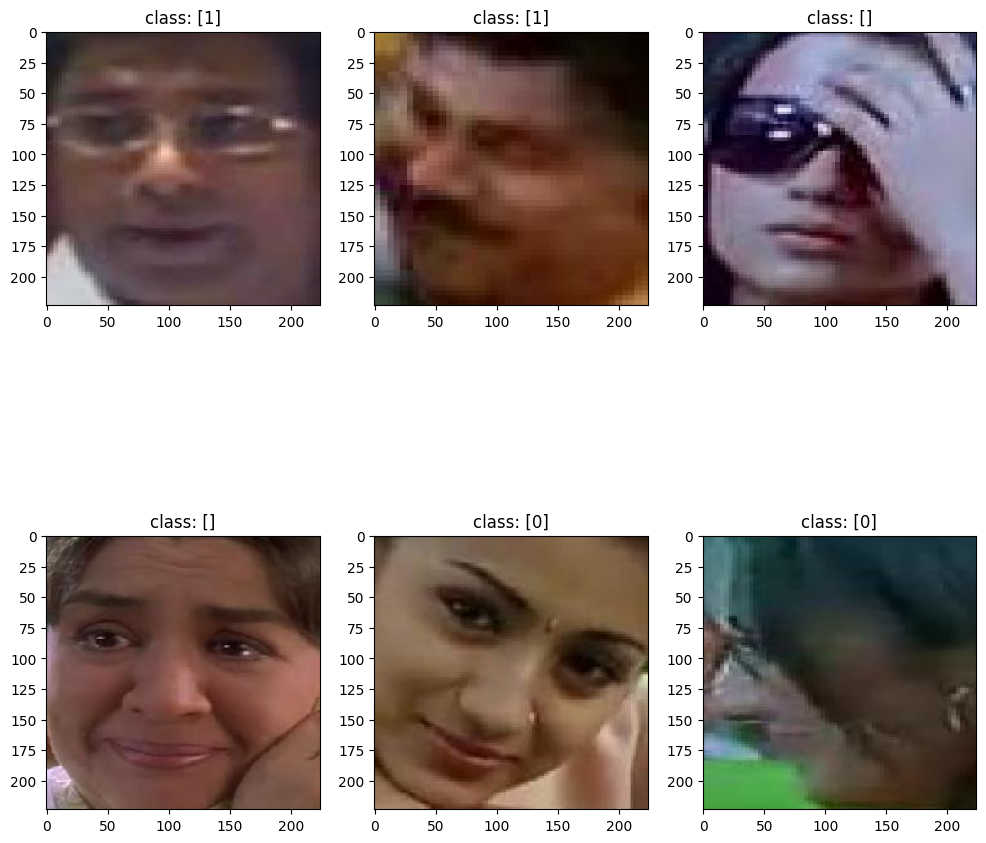

In [ ]:
# prompt: visualize 6 images using a list of images and matplotlib

import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(train_images[i])

  plt.title(f"class: {train_labels[i]}")
plt.show()


# Chargement des donnees

In [ ]:
import pandas as pd
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import os

# Lire le CSV
df = pd.read_csv('/content/images/train.csv')

# Échantillonnage de 6000 images aléatoires
df_sample = df.sample(n=6000, random_state=42).reset_index(drop=True)

# Fonction pour charger les images
def read_images_from_df(df, image_dir, size=(128, 128)):  # Taille par défaut conservée
    images = []
    labels = []
    for _, row in df.iterrows():
        image_path = os.path.join(image_dir, row['image_names'])
        if os.path.exists(image_path):
            img = imread(image_path)
            img = resize(img, size)
            images.append(img)
            labels.append(row['class'])
    return np.array(images), np.array(labels)

# Chargement des données
image_dir = '/content/images/images'
images, labels = read_images_from_df(df_sample, image_dir)

print("✅ Chargement terminé")
print("images shape:", images.shape)
print("labels shape:", labels.shape)


✅ Chargement terminé
images shape: (6000, 128, 128, 3)
labels shape: (6000,)


# Pretraitement des donnees

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
# Transforms avec data augmentation
transform = transforms.Compose([
    transforms.ToPILImage(),
    #transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])



In [ ]:
import torch
import torch.nn.functional as F
# Appliquer le transform sur toutes les images
augmented_images = torch.stack([
    transform(img) for img in images
])

print(augmented_images.shape)

torch.Size([6000, 3, 128, 128])


In [ ]:
#visualisation des images augmente

In [ ]:
X = augmented_images.view(augmented_images.size(0), -1)

In [ ]:
#Tranformer label en tenseur
y = torch.tensor(labels)
y = torch.tensor(labels, dtype=torch.float32)  # 0.0 ou 1.0


# Construction du modele

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# === Construction du modèle MLP ===
class MLP(nn.Module):
    def __init__(self, input_size=3*128*128, dropout=0.2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.dropout = nn.Dropout(dropout)
        self.output = nn.Linear(256, 1)  # Sortie unique pour BCE

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.output(x)  # Pas de sigmoid

# === EarlyStopping personnalisé ===
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# === Compilation et entraînement ===
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=50):
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )
    early_stopping = EarlyStopping(patience=5)

    model.to(device)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(torch.sigmoid(outputs), labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            running_corrects += (preds == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation
        model.eval()
        val_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(torch.sigmoid(outputs), labels)
                val_loss += loss.item() * inputs.size(0)
                preds = (torch.sigmoid(outputs) > 0.5).float()
                val_corrects += (preds == labels).sum().item()

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_corrects / len(val_loader.dataset)
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_acc)

        # Scheduler et EarlyStopping
        scheduler.step(val_epoch_loss)
        early_stopping(val_epoch_loss)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} - Val Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.4f}")

        if early_stopping.early_stop:
            print("Early stopping déclenché.")
            break

    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)
    return model

# === Fonctions utilitaires ===
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title("Courbe de perte")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.title("Courbe d'accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_loader, device, target_names):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).int()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Matrice de confusion")
    plt.show()

    print(classification_report(all_labels, all_preds, target_names=target_names))


# Division du Dataset en Train/Val

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# X et y sont déjà normalisés et encodés (cf étapes précédentes)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Entrainement du model

Epoch 1/50 - Train Loss: 0.7008, Acc: 0.6587 - Val Loss: 0.5392, Acc: 0.7342
Epoch 2/50 - Train Loss: 0.5273, Acc: 0.7398 - Val Loss: 0.5087, Acc: 0.7508
Epoch 3/50 - Train Loss: 0.5097, Acc: 0.7610 - Val Loss: 0.5954, Acc: 0.6783
Epoch 4/50 - Train Loss: 0.4923, Acc: 0.7688 - Val Loss: 0.4847, Acc: 0.7675
Epoch 5/50 - Train Loss: 0.4471, Acc: 0.7965 - Val Loss: 0.5364, Acc: 0.7092
Epoch 6/50 - Train Loss: 0.4239, Acc: 0.8008 - Val Loss: 0.4716, Acc: 0.7575
Epoch 7/50 - Train Loss: 0.4160, Acc: 0.8213 - Val Loss: 0.4570, Acc: 0.7767
Epoch 8/50 - Train Loss: 0.3819, Acc: 0.8275 - Val Loss: 0.4604, Acc: 0.7958
Epoch 9/50 - Train Loss: 0.3847, Acc: 0.8244 - Val Loss: 0.4654, Acc: 0.7950
Epoch 10/50 - Train Loss: 0.3715, Acc: 0.8352 - Val Loss: 0.4164, Acc: 0.8050
Epoch 11/50 - Train Loss: 0.3322, Acc: 0.8519 - Val Loss: 0.4430, Acc: 0.8008
Epoch 12/50 - Train Loss: 0.3158, Acc: 0.8596 - Val Loss: 0.4443, Acc: 0.7858
Epoch 13/50 - Train Loss: 0.3146, Acc: 0.8562 - Val Loss: 0.6309, Acc: 0.

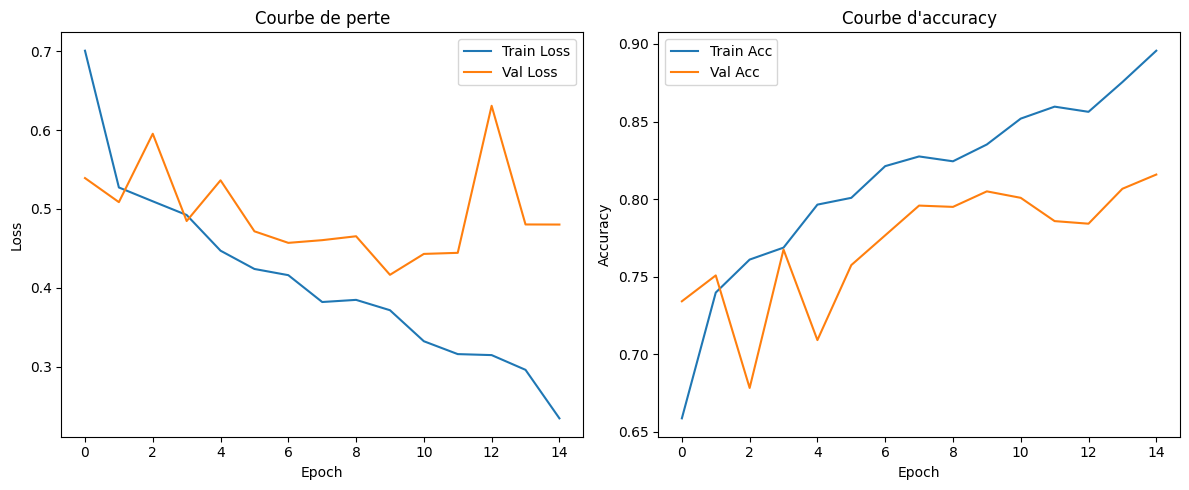

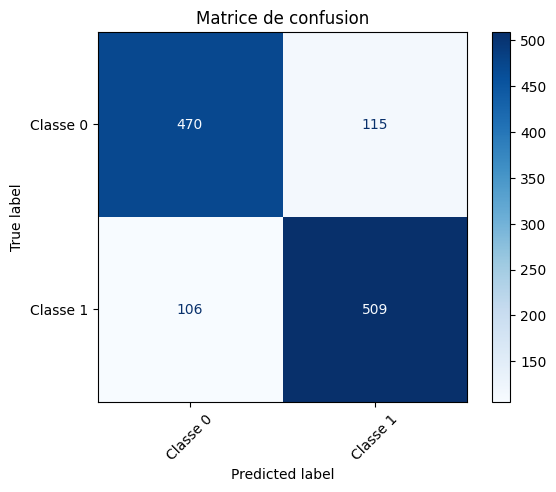

              precision    recall  f1-score   support

    Classe 0       0.82      0.80      0.81       585
    Classe 1       0.82      0.83      0.82       615

    accuracy                           0.82      1200
   macro avg       0.82      0.82      0.82      1200
weighted avg       0.82      0.82      0.82      1200



In [ ]:

model = MLP()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
  optimizer, mode='min', factor=0.5, patience=3
)
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=50)
evaluate_model(trained_model, val_loader, device, target_names=["Classe 0", "Classe 1"])


# Interpretation des resultats


### **Analyse des performances du modèle**

* **Apprentissage** :

  * Le modèle a été entraîné pendant 15 époques avant que l’**early stopping** ne soit déclenché, ce qui signifie que la performance sur les données de validation cessait de s'améliorer, évitant ainsi le surapprentissage.
  * **Amélioration notable** de la précision validation : de **73% (epoch 1)** à **\~81% (epoch 15)**.
  * La **meilleure performance de validation** a été obtenue à l’époque 15 avec une perte de validation de **0.48** et une précision de **81.6%**.

* **Évaluation finale (sur 1200 images de test)** :

  * **Exactitude globale (accuracy)** : **82%**
  * **F1-score équilibré** entre les deux classes (Classe 0 et Classe 1) : **0.81–0.82**, montrant que le modèle est bien équilibré.
  * **Précision et rappel similaires** pour chaque classe, ce qui indique que le modèle ne favorise pas l’une des deux.








#  Predictions sur les donnees de test

In [ ]:
import pandas as pd
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import os

# Lire le CSV
df_test = pd.read_csv('/content/VisageModel/test_vis.csv')

# Échantillonnage de 1200 images aléatoires
df_sample = df_test.sample(n=1200, random_state=42).reset_index(drop=True)

# Fonction pour charger les images
def read_images_from_df(df_test, image_dir, size=(128, 128)):  # Taille par défaut conservée
    images = []
    #labels = []
    for _, row in df_test.iterrows():
        image_path = os.path.join(image_dir, row['image_names'])
        if os.path.exists(image_path):
            img = imread(image_path)
            img = resize(img, size)
            images.append(img)
            #labels.append(row['class'])
    return np.array(images) #, np.array(labels)

# Chargement des données
image_dir = '/content/images/images'
images= read_images_from_df(df_sample, image_dir)

print("✅ Chargement terminé")
print("images shape:", images.shape)
#print("labels shape:", labels.shape)


✅ Chargement terminé
images shape: (1200, 128, 128, 3)


In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
transform_test = transforms.Compose([
    transforms.ToPILImage(),
    # transforms.Resize((128, 128)),  # active-le si tes images doivent être redimensionnées
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [ ]:
import torch
import torch.nn.functional as F
# Appliquer le transform sur toutes les images
Transform_appli = torch.stack([
    transform_test(img) for img in images
])

print(Transform_appli.shape)

torch.Size([1200, 3, 128, 128])


In [ ]:
X_test = Transform_appli.view(Transform_appli.size(0), -1)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset # Import TensorDataset

test_dataset = TensorDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
# Liste des noms d’images utilisés pour la prédiction (correspond à df_sample)
image_names = df_sample['image_names'].tolist()

# Prédictions
model.eval()
all_preds = []

with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0].to(device)
        outputs = model(inputs)
        predicted = (outputs >= 0.5).int()
        all_preds.extend(predicted.cpu().numpy().flatten().tolist())

# Vérification
assert len(image_names) == len(all_preds), "Le nombre d’images ≠ nombre de prédictions"

# Sauvegarde
df_output = pd.DataFrame({
    'image_name': image_names,
    'prediction': all_preds
})
df_output.to_csv("predictions.csv", index=False)


In [ ]:
df_output

,image_name,prediction
0,26476.jpg,0
1,1504.jpg,1
2,395.jpg,0
3,4402.jpg,1
4,1939.jpg,1
...,...,...
1195,207.jpg,0
1196,6252.jpg,0
1197,4982.jpg,1
1198,17314.jpg,0
